In [46]:
%reload_ext autoreload
%autoreload 2

import time

import torch

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from datasets import *
from models import *
from losses import *

In [47]:
device = 'cpu'

In [48]:
data_generator = GaussianDataset(
    [lambda x: -3 * x, lambda x: 3 * x],
    torch.tensor([0.5, 0.5], dtype=torch.float32),
    torch.tensor([0.5, 0.5], dtype=torch.float32),
    poly=3,
    device=device
)

data_generator.generate_data(100000, 1)
train_loader = torch.utils.data.DataLoader(data_generator, batch_size=5000, shuffle=True)

print('mean:', round(torch.mean(data_generator.y).item(), 2), 'std:', round(torch.std(data_generator.y).item(), 2))

data_generator.generate_data(1000, 1)
test_loader = torch.utils.data.DataLoader(data_generator, batch_size=1000, shuffle=True)

mean: 0.01 std: 1.8


In [56]:
test_model = GaussianTransform(3, [2], 1, [2], 1)

# show parameter values
for name, param in test_model.named_parameters():
    print(name, param.data)

mu_encoder.0.weight tensor([[-0.2070,  0.3760, -0.4721],
        [ 0.1958,  0.4639, -0.0140]])
mu_encoder.0.bias tensor([0.0266, 0.1421])
mu_encoder.output.weight tensor([[-0.5855,  0.0869]])
mu_encoder.output.bias tensor([-0.0899])
log_var_encoder.0.weight tensor([[-0.1194,  0.2004,  0.0199],
        [ 0.0519,  0.5230,  0.1084]])
log_var_encoder.0.bias tensor([-0.3291, -0.4162])
log_var_encoder.output.weight tensor([[-0.3929, -0.1153]])
log_var_encoder.output.bias tensor([0.2575])
decoder.0.weight tensor([[ 0.3212],
        [-0.2985]])
decoder.0.bias tensor([0.1387, 0.7543])
decoder.output.weight tensor([[0.1818, 0.2552]])
decoder.output.bias tensor([-0.2741])


In [57]:
model_medium = GaussianTransform(3, [2], 1, [2], 1)
epochs = 10
lr = 0.01
optim = torch.optim.Adam(model_medium.parameters(), lr=lr)
loss_fn = JS_loss

loss = torch.tensor(float('inf'))
for epoch in range(epochs):
    model_medium.train()
    if epoch % 1 == 0:
        print('Epoch:', epoch, 'to', epoch+1, 'Loss:', round(loss.item(), 2), end='\r', flush=True)
        time.sleep(3)

    for X, y in train_loader:
        optim.zero_grad()
        y_pred = model_medium(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optim.step()

    if epoch % 500 == 0:
        lr /= 2
        optim = torch.optim.Adam(model_medium.parameters(), lr=lr)
    
    '''
    if epoch % 100 == 0:
        clear_output(wait=True)
        model_medium.eval()
        X_test_list, y_test_list, y_pred_list, mu_pred_list = [], [], [], []
        with torch.no_grad():
            for X, y in test_loader:
                X_test_list += X[:, 0].flatten().tolist()
                y_test_list += y.flatten().tolist()
                y_pred, mu, log_var = model_medium(X)
                y_pred_list += y_pred.flatten().tolist()
                mu_pred_list += mu.mean(dim=1).flatten().tolist()
                loss_fn(y_pred, y, mu, log_var)

        plt.plot(X_test_list, y_pred_list, 'o', label='Predicted')
        plt.plot(X_test_list, y_test_list, 'o', label='True')
        # plt.plot(X_test_list, mu_pred_list, 'o', label='Mean')
        # plt.plot(X_test_list, np.array(X_test_list)*5, label='True')
        plt.legend()
        plt.ylim(-5, 5)
        plt.show()'''

KeyboardInterrupt: 

/opt/homebrew/anaconda3/envs/DistributionFitting/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/homebrew/anaconda3/envs/DistributionFitting/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

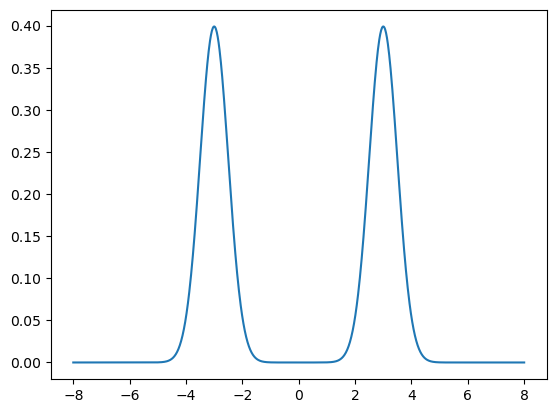

In [28]:
x = 1.
X = torch.full((1000000, 3), x)
y = np.linspace(-8, 8, 1000)
y_distr = data_generator.y_curve(x, y)
with torch.no_grad():
    y_pred = model_medium(X)

plt.plot(y, y_distr, label='True')
plt.hist(y_pred.flatten(), bins=100, density=True)
plt.legend()
plt.show()